In [1]:
import numpy as np
import pickle
import statistics
import matplotlib.pyplot as plt
import sys
import pickle

from xgboost import XGBClassifier
from sympy.core.numbers import igcd
from datetime import datetime

from sklearn import preprocessing
from sklearn import svm
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import MinMaxScaler,QuantileTransformer,RobustScaler,StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import time
import random
from scipy import stats


from pyod.models.hbos import HBOS
from pyod.models.cblof import CBLOF
from pyod.models.loci import LOCI
from pyod.models.xgbod import XGBOD
from pyod.models.cof import COF
from pyod.models.loda import LODA
from pyod.models.copod import COPOD
from pyod.models.sod import SOD
from pyod.models.vae import VAE
from pyod.models.lof import LocalOutlierFactor,LOF
from pyod.models.lscp import LSCP
from pyod.models.so_gaal import SO_GAAL
from pyod.models.mo_gaal import MO_GAAL
from pyod.models.iforest import IForest
from pyod.models.ocsvm import OCSVM
from pyod.models.auto_encoder import AutoEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout,LSTM, Conv1D, MaxPooling1D, AveragePooling1D, Flatten,Reshape,UpSampling1D
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.manifold import TSNE
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In /home/pedromiguel/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/pedromiguel/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/pedromiguel/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/pedromiguel/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/pedromiguel/anaconda3/lib/pytho

In [2]:
#Generates the autoencoder 
def gen_autoencoder(X_train,encoding_dim):
    
    input_dim = X_train.shape[1] # the # features

    input_layer = Input(shape=(input_dim, ))
    hidden = Dense(encoding_dim[0], activation="relu")(input_layer)
    for n_neurons in encoding_dim[1:]:
        hidden = Dense(n_neurons, activation="relu")(hidden)#, activity_regularizer=regularizers.l1(10e-5))(input_layer)    
        #hidden = Dropout(0.5)(hidden)
    
    hidden = Dense(input_dim, activation="sigmoid")(hidden)
    
    autoencoder = Model(inputs=input_layer, outputs=hidden)
    opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    autoencoder.compile(loss='mean_squared_error', optimizer = opt,metrics=['acc'])
    return autoencoder

#Get anomaly threshold from "autoencoder" setting the threshold in Q1,Q3+-1.5IQR
def get_threshold_mse_iqr(autoencoder,train_data):
    if("pyod" in str(type(autoencoder))):
        return get_threshold_ml_score_iqr(autoencoder,train_data)
    
    train_predicted = autoencoder.predict(train_data)
    mse = np.mean(np.power(train_data - train_predicted, 2), axis=1)
    iqr = np.quantile(mse,0.75) - np.quantile(mse, 0.25)
    up_bound = np.quantile(mse,0.75) + 1.5*iqr
    bottom_bound = np.quantile(mse,0.25) - 1.5*iqr
    
    #plt.hist(mse, bins = 100,label="mse")
    #plt.xlim(0,0.2)
    #plt.legend()
    #plt.show()
    
    thres = [up_bound,bottom_bound]
    return thres

#Get anomaly threshold from "autoencoder" setting the threshold in "train_data" using "outlier_percentage"
def get_threshold_mse_percentage(autoencoder,train_data,outlier_percentage):
    train_predicted = autoencoder.predict(train_data)
    mse = np.mean(np.power(train_data - train_predicted, 2), axis=1)
    thresh = np.quantile(mse, 1-outlier_percentage)
    return [thresh]

#Predict outliers in "df" using "autoencoder" model and "threshold_mse" as anomaly limit
def detect_outliers(autoencoder, df, threshold_mse):
    if("pyod" in str(type(autoencoder))):
        return detect_outliers_range_ml(autoencoder,df,threshold_mse)
    
    if(len(threshold_mse)==2):
        return detect_outliers_range(autoencoder, df, threshold_mse)
    pred=autoencoder.predict(df)
    mse = np.mean(np.power(df - pred, 2), axis=1)
    
    #mse_plot = mse[mse>np.percentile(mse,0.95)]
    #plt.hist(mse_plot, bins=100)
    #plt.show()
    outliers = [(np.array(mse) < threshold_mse)]
    return outliers



def detect_outliers_range(autoencoder, df, threshold_mse):
    pred=autoencoder.predict(df)
    mse = np.mean(np.power(df - pred, 2), axis=1)
    
    #mse_plot = mse[mse>np.percentile(mse,0.95)]
    #plt.hist(mse_plot, bins=100)
    #plt.show()
    
    up_bound = threshold_mse[0]
    bottom_bound = threshold_mse[1]
    #outliers = [(np.array(mse) < up_bound)&(np.array(mse) > bottom_bound)]
    outliers = [(np.array(mse) < up_bound)]
    return outliers
    

#Evaluate the anomalies in "df" using pyod ml "model" based on the threshold "threshold_mse", the threshold is a list with upper and lower values for the anomalies
def detect_outliers_range_ml(model, df, threshold_mse):
    mse=model.decision_function(df)
    up_bound = threshold_mse[0]
    bottom_bound = threshold_mse[1]
    outliers = [(np.array(mse) < up_bound)&(np.array(mse) > bottom_bound)]
    return outliers

#Get anomaly threshold from pyod ml "model" setting the threshold in Q1,Q3+-1.5IQR
def get_threshold_ml_score_iqr(model,train_data):
    mse = model.decision_function(train_data)
    iqr = np.quantile(mse,0.75) - np.quantile(mse, 0.25)
    up_bound = np.quantile(mse,0.75) + 1.5*iqr
    bottom_bound = np.quantile(mse,0.25) - 1.5*iqr
    thres = [up_bound,bottom_bound]
    return thres

In [3]:
def plot_hist(data):
    fig,ax = plt.subplots()
    fig.set_size_inches(10.5, 7.5, forward=True)
    plt.hist(data, bins = 1000)
    plt.show()

In [4]:
#Pedro
df_Rasp3_pedro = pd.read_csv("../Datasets/final_dataset_2/b8_27_eb_63_5b_27")

#CYD
df_Rasp3_1_CYD = pd.read_csv("../Datasets/final_dataset_2/b8_27_eb_10_a7_e6")
df_Rasp3_2_CYD = pd.read_csv("../Datasets/final_dataset_2/b8_27_eb_a9_15_d1")

#UZH
df_Rasp3_1_UZH = pd.read_csv("../Datasets/final_dataset_2/b8_27_eb_55_3d_95")
df_Rasp3_2_UZH = pd.read_csv("../Datasets/final_dataset_2/b8_27_eb_45_3f_c5")
df_Rasp3_3_UZH = pd.read_csv("../Datasets/final_dataset_2/b8_27_eb_e0_85_25")



#Remove connectivy feature
#df_Rasp3_pedro.drop(['connectivity'],axis=1,inplace=True)
df_Rasp3_pedro.drop(['connectivity'],axis=1,inplace=True)

#Remove time feature
#df_Rasp3_pedro.drop(['time'],axis=1,inplace=True)
df_Rasp3_pedro.drop(['time'],axis=1,inplace=True)


    
#Split Normal to get the list of features without constant values used to filter the dataset
df_Rasp3_pedro_normal = df_Rasp3_pedro.loc[(df_Rasp3_pedro['timestamp'] > 1637578547000)  & (df_Rasp3_pedro['timestamp'] < 1638281248758)]
df_Rasp3_1_CYD_normal = df_Rasp3_1_CYD.loc[(df_Rasp3_1_CYD['timestamp'] > 1637578547000)  & (df_Rasp3_1_CYD['timestamp'] < 1638281248758)]
df_Rasp3_2_CYD_normal = df_Rasp3_2_CYD.loc[(df_Rasp3_2_CYD['timestamp'] > 1637578547000)  & (df_Rasp3_2_CYD['timestamp'] < 1638281248758)]
df_Rasp3_1_UZH_normal = df_Rasp3_1_UZH.loc[(df_Rasp3_1_UZH['timestamp'] > 1637578547000)  & (df_Rasp3_1_UZH['timestamp'] < 1638281248758)]
df_Rasp3_2_UZH_normal = df_Rasp3_2_UZH.loc[(df_Rasp3_2_UZH['timestamp'] > 1637578547000) & (df_Rasp3_2_UZH['timestamp'] < 1638281248758)]
df_Rasp3_3_UZH_normal = df_Rasp3_3_UZH.loc[(df_Rasp3_3_UZH['timestamp'] > 1637578547000)  & (df_Rasp3_3_UZH['timestamp'] < 1638281248758)]   


#Filter constant values
df_Rasp3_pedro = df_Rasp3_pedro.loc[:,(df_Rasp3_pedro_normal.apply(pd.Series.nunique) != 1) & (df_Rasp3_1_CYD_normal.apply(pd.Series.nunique) != 1) & (df_Rasp3_2_CYD_normal.apply(pd.Series.nunique) != 1)  & (df_Rasp3_1_UZH_normal.apply(pd.Series.nunique) != 1) & (df_Rasp3_2_UZH_normal.apply(pd.Series.nunique) != 1) &  (df_Rasp3_3_UZH_normal.apply(pd.Series.nunique) != 1)  ]

#Save the list features with non-constant values
feat_list=df_Rasp3_pedro.columns

df_Rasp3_pedro = df_Rasp3_pedro[df_Rasp3_pedro.columns.intersection(feat_list)]
df_Rasp3_1_CYD = df_Rasp3_1_CYD[df_Rasp3_1_CYD.columns.intersection(feat_list)]
df_Rasp3_2_CYD = df_Rasp3_2_CYD[df_Rasp3_2_CYD.columns.intersection(feat_list)]
df_Rasp3_1_UZH = df_Rasp3_1_UZH[df_Rasp3_1_UZH.columns.intersection(feat_list)]
df_Rasp3_2_UZH = df_Rasp3_2_UZH[df_Rasp3_2_UZH.columns.intersection(feat_list)]
df_Rasp3_3_UZH = df_Rasp3_3_UZH[df_Rasp3_3_UZH.columns.intersection(feat_list)]


df_Rasp3_1_CYD = df_Rasp3_1_CYD[df_Rasp3_1_CYD.columns.intersection(feat_list)]
df_Rasp3_2_CYD = df_Rasp3_2_CYD[df_Rasp3_2_CYD.columns.intersection(feat_list)]
df_Rasp3_1_UZH = df_Rasp3_1_UZH[df_Rasp3_1_UZH.columns.intersection(feat_list)]
df_Rasp3_2_UZH = df_Rasp3_2_UZH[df_Rasp3_2_UZH.columns.intersection(feat_list)]
df_Rasp3_3_UZH = df_Rasp3_3_UZH[df_Rasp3_3_UZH.columns.intersection(feat_list)]


#Normal
df_Rasp3_pedro_normal = df_Rasp3_pedro.loc[(df_Rasp3_pedro['timestamp'] > 1637578547000)  & (df_Rasp3_pedro['timestamp'] < 1638281248758)]
df_Rasp3_1_CYD_normal = df_Rasp3_1_CYD.loc[(df_Rasp3_1_CYD['timestamp'] > 1637578547000)  & (df_Rasp3_1_CYD['timestamp'] < 1638281248758)]
df_Rasp3_2_CYD_normal = df_Rasp3_2_CYD.loc[(df_Rasp3_2_CYD['timestamp'] > 1637578547000)  & (df_Rasp3_2_CYD['timestamp'] < 1638281248758)]
df_Rasp3_1_UZH_normal = df_Rasp3_1_UZH.loc[(df_Rasp3_1_UZH['timestamp'] > 1637578547000)  & (df_Rasp3_1_UZH['timestamp'] < 1638281248758)]
df_Rasp3_2_UZH_normal = df_Rasp3_2_UZH.loc[(df_Rasp3_2_UZH['timestamp'] > 1637578547000) & (df_Rasp3_2_UZH['timestamp'] < 1638281248758)]
df_Rasp3_3_UZH_normal = df_Rasp3_3_UZH.loc[(df_Rasp3_3_UZH['timestamp'] > 1637578547000)  & (df_Rasp3_3_UZH['timestamp'] < 1638281248758)]   

print(df_Rasp3_pedro_normal.shape)

(12172, 73)


In [5]:
#RASPBERRY Pi 4


#CYD
df_Rasp4_CYD = pd.read_csv("../Datasets/final_dataset_2/dc_a6_32_4c_9a_d0")

#UZH
df_Rasp4_UZH = pd.read_csv("../Datasets/final_dataset_2/e4_5f_01_15_dd_f2")

#UMU
df_Rasp4_UMU = pd.read_csv("../Datasets/final_dataset_2/dc_a6_32_e4_48_cb")


#Remove connectivy feature
df_Rasp4_CYD.drop(['connectivity'],axis=1,inplace=True)

#Remove time feature
df_Rasp4_CYD.drop(['time'],axis=1,inplace=True)



df_Rasp4_CYD = df_Rasp4_CYD[df_Rasp4_CYD.columns.intersection(feat_list)]
df_Rasp4_UZH = df_Rasp4_UZH[df_Rasp4_UZH.columns.intersection(feat_list)]
df_Rasp4_UMU = df_Rasp4_UMU[df_Rasp4_UMU.columns.intersection(feat_list)]

#Split dataset (normal/attack types)

#Normal
df_Rasp4_CYD_normal = df_Rasp4_CYD.loc[(df_Rasp4_CYD['timestamp'] > 1637578547000)  & (df_Rasp4_CYD['timestamp'] < 1638281248758)]
df_Rasp4_UZH_normal = df_Rasp4_UZH.loc[(df_Rasp4_UZH['timestamp'] > 1637578547000)  & (df_Rasp4_UZH['timestamp'] < 1638281248758)]
df_Rasp4_UMU_normal = df_Rasp4_UMU.loc[(df_Rasp4_UMU['timestamp'] > 1637578547000)  & (df_Rasp4_UMU['timestamp'] < 1638281248758)]

df_Rasp4_UZH_normal = df_Rasp4_UZH_normal.loc[:, (df_Rasp4_UZH_normal != df_Rasp4_UZH_normal.iloc[0]).any()]

print(df_Rasp4_UZH_normal.shape)

/home/pedromiguel/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(12283, 73)


In [6]:
# Split datasets in train and test
df_Rasp3_pedro_normal_train, df_Rasp3_pedro_normal_test = train_test_split(df_Rasp3_pedro_normal, test_size=0.2, random_state=42, shuffle=False)
df_Rasp3_1_CYD_normal_train, df_Rasp3_1_CYD_normal_test = train_test_split(df_Rasp3_1_CYD_normal, test_size=0.2, random_state=42, shuffle=False)
df_Rasp3_2_CYD_normal_train, df_Rasp3_2_CYD_normal_test = train_test_split(df_Rasp3_2_CYD_normal, test_size=0.2, random_state=42, shuffle=False)
df_Rasp3_1_UZH_normal_train, df_Rasp3_1_UZH_normal_test = train_test_split(df_Rasp3_1_UZH_normal, test_size=0.2, random_state=42, shuffle=False)
df_Rasp3_2_UZH_normal_train, df_Rasp3_2_UZH_normal_test = train_test_split(df_Rasp3_2_UZH_normal, test_size=0.2, random_state=42, shuffle=False)
df_Rasp3_3_UZH_normal_train, df_Rasp3_3_UZH_normal_test = train_test_split(df_Rasp3_3_UZH_normal, test_size=0.2, random_state=42, shuffle=False)


# Split datasets in train and test
df_Rasp4_CYD_normal_train, df_Rasp4_CYD_normal_test = train_test_split(df_Rasp4_CYD_normal, test_size=0.2, random_state=42, shuffle=False)
df_Rasp4_UZH_normal_train, df_Rasp4_UZH_normal_test = train_test_split(df_Rasp4_UZH_normal, test_size=0.2, random_state=42, shuffle=False)
df_Rasp4_UMU_normal_train, df_Rasp4_UMU_normal_test = train_test_split(df_Rasp4_UMU_normal, test_size=0.2, random_state=42, shuffle=False)


In [7]:
#Filter Outliers from the training 
df_Rasp3_pedro_normal_train=df_Rasp3_pedro_normal_train[(np.abs(stats.zscore(df_Rasp3_pedro_normal_train)) < 3).all(axis=1)]
df_Rasp3_1_CYD_normal_train=df_Rasp3_1_CYD_normal_train[(np.abs(stats.zscore(df_Rasp3_1_CYD_normal_train)) < 3).all(axis=1)]
df_Rasp3_2_CYD_normal_train=df_Rasp3_2_CYD_normal_train[(np.abs(stats.zscore(df_Rasp3_2_CYD_normal_train)) < 3).all(axis=1)]
df_Rasp3_1_UZH_normal_train=df_Rasp3_1_UZH_normal_train[(np.abs(stats.zscore(df_Rasp3_1_UZH_normal_train)) < 3).all(axis=1)]
df_Rasp3_2_UZH_normal_train=df_Rasp3_2_UZH_normal_train[(np.abs(stats.zscore(df_Rasp3_2_UZH_normal_train)) < 3).all(axis=1)]
df_Rasp3_3_UZH_normal_train=df_Rasp3_3_UZH_normal_train[(np.abs(stats.zscore(df_Rasp3_3_UZH_normal_train)) < 3).all(axis=1)]
df_Rasp4_CYD_normal_train=df_Rasp4_CYD_normal_train[(np.abs(stats.zscore(df_Rasp4_CYD_normal_train)) < 3).all(axis=1)]
df_Rasp4_UZH_normal_train=df_Rasp4_UZH_normal_train[(np.abs(stats.zscore(df_Rasp4_UZH_normal_train)) < 3).all(axis=1)]
df_Rasp4_UMU_normal_train=df_Rasp4_UMU_normal_train[(np.abs(stats.zscore(df_Rasp4_UMU_normal_train)) < 3).all(axis=1)]

In [8]:
df_list_normal_train = [pd.concat([df_Rasp3_pedro_normal_train, df_Rasp3_1_CYD_normal_train, df_Rasp3_2_CYD_normal_train, df_Rasp3_1_UZH_normal_train, df_Rasp3_2_UZH_normal_train, df_Rasp3_3_UZH_normal_train]), pd.concat([df_Rasp4_CYD_normal_train, df_Rasp4_UZH_normal_train, df_Rasp4_UMU_normal_train])]
df_list_normal_test = [pd.concat([df_Rasp3_pedro_normal_test, df_Rasp3_1_CYD_normal_test, df_Rasp3_2_CYD_normal_test, df_Rasp3_1_UZH_normal_test, df_Rasp3_2_UZH_normal_test, df_Rasp3_3_UZH_normal_test]), pd.concat([df_Rasp4_CYD_normal_test, df_Rasp4_UZH_normal_test, df_Rasp4_UMU_normal_test])]


In [9]:
device_list=["df_Rasp3", "df_Rasp4"]
attacks_df_lists={}
timestamps={}
timestamps["noise"]=[1634048100000+3600000*12, 1639499851331, 1639689114465, 1639529420078, 1639558871523, 1639588297538]
timestamps["delay"]=[1636542042000+3600000*12, 1638809715000, 1638873523000, 1639043946000, 1639258059000, 1639353084000]
timestamps["spoof"]=[1634541000000+3600000*12, 1639507344866, 1639698299157, 1639536783235, 1639566227524, 1639595653590]
timestamps["mimic"]=[1636963242000+3600000*12, 1638825148000, 1638888205000, 1639060436000, 1639272702000, 1639367733000]
timestamps["confusion"]=[1635427800000+3600000*12, 1639514701938, 1639705655398, 1639544145992, 1639573584011, 1639603010791]
timestamps["repeat"]=[1635751800000, 1639522060524, 1639713007186, 1639551508810, 1639580941337, 1639610368534]


for d in device_list:
    attacks_df_lists[d]={}
    for a in timestamps.keys():
        attacks_df_lists[d][a]=[]

In [10]:
for k in timestamps.keys():
    for i in timestamps[k]:

        df_Rasp3_pedro_attack = df_Rasp3_pedro.loc[(df_Rasp3_pedro['timestamp'] > i)  & (df_Rasp3_pedro['timestamp'] < i+7200000)]
        df_Rasp3_1_CYD_attack = df_Rasp3_1_CYD.loc[(df_Rasp3_1_CYD['timestamp'] > i)  & (df_Rasp3_1_CYD['timestamp'] < i+7200000)]
        df_Rasp3_2_CYD_attack = df_Rasp3_2_CYD.loc[(df_Rasp3_2_CYD['timestamp'] > i)  & (df_Rasp3_2_CYD['timestamp'] < i+7200000)]
        df_Rasp3_1_UZH_attack = df_Rasp3_1_UZH.loc[(df_Rasp3_1_UZH['timestamp'] > i)  & (df_Rasp3_1_UZH['timestamp'] < i+7200000)]        
        df_Rasp3_2_UZH_attack = df_Rasp3_2_UZH.loc[(df_Rasp3_2_UZH['timestamp'] > i) & (df_Rasp3_2_UZH['timestamp'] < i+7200000)]        
        df_Rasp3_3_UZH_attack = df_Rasp3_3_UZH.loc[(df_Rasp3_3_UZH['timestamp'] > i)  & (df_Rasp3_3_UZH['timestamp'] < i+7200000)]   

        df_Rasp3_attack=pd.concat([df_Rasp3_pedro_attack,df_Rasp3_1_CYD_attack, df_Rasp3_2_CYD_attack, df_Rasp3_1_UZH_attack, df_Rasp3_2_UZH_attack, df_Rasp3_3_UZH_attack])
        
        attacks_df_lists["df_Rasp3"][k].append(df_Rasp3_attack)

            
        df_Rasp4_CYD_attack = df_Rasp4_CYD.loc[(df_Rasp4_CYD['timestamp'] > i)  & (df_Rasp4_CYD['timestamp'] < i+7200000)]
        df_Rasp4_UZH_attack = df_Rasp4_UZH.loc[(df_Rasp4_UZH['timestamp'] > i)  & (df_Rasp4_UZH['timestamp'] < i+7200000)]
        df_Rasp4_UMU_attack = df_Rasp4_UMU.loc[(df_Rasp4_UMU['timestamp'] > i)  & (df_Rasp4_UMU['timestamp'] < i+7200000)]
        
        df_Rasp4_attack=pd.concat([df_Rasp4_CYD_attack,df_Rasp4_UZH_attack,df_Rasp4_UMU_attack])
        
        attacks_df_lists["df_Rasp4"][k].append(df_Rasp4_attack)


In [11]:
model_names=["autoencoder","if", "lof", "copod", "ocsvm"]
results={}
for a in timestamps.keys():
    results[a]={}
    for m in model_names:
        results[a][m]={}
        for f in range(6):
            results[a][m][f]={}


In [12]:
"""import warnings
warnings.filterwarnings("ignore")

for dev in range(len(device_list)):
    df_train=df_list_normal_train[dev]
    df_train['timestamp_plot']=df_train['timestamp'].apply(lambda x: mdates.epoch2num(int(x)/1000))
    d=device_list[dev]
    for feat_hist in feat_list:
        for df in attacks_df_lists[d]["repeat"]:
                df['timestamp_plot']=df['timestamp'].apply(lambda x: mdates.epoch2num(int(x)/1000))
                data_hist_0 = df[feat_hist]
                plt.rcParams["figure.figsize"] = (20,6)
                plt.plot(df['timestamp_plot'],data_hist_0,label=feat_hist+"_"+d,color="blue",marker='.',linestyle="None", alpha=0.2)
        data_hist_0 = df_train[feat_hist]
        plt.plot(df_train['timestamp_plot'],data_hist_0,label=feat_hist+"_"+d,color="blue",marker='.',linestyle="None", alpha=0.2)
        myFmt = mdates.DateFormatter("%b %d %Y %H:%M")
        plt.gca().xaxis.set_major_formatter(myFmt)
        #plt.plot(data_hist_f,label=feat_hist+"_f",color="b")
        plt.legend()
        plt.show()"""

'import warnings\nwarnings.filterwarnings("ignore")\n\nfor dev in range(len(device_list)):\n    df_train=df_list_normal_train[dev]\n    df_train[\'timestamp_plot\']=df_train[\'timestamp\'].apply(lambda x: mdates.epoch2num(int(x)/1000))\n    d=device_list[dev]\n    for feat_hist in feat_list:\n        for df in attacks_df_lists[d]["repeat"]:\n                df[\'timestamp_plot\']=df[\'timestamp\'].apply(lambda x: mdates.epoch2num(int(x)/1000))\n                data_hist_0 = df[feat_hist]\n                plt.rcParams["figure.figsize"] = (20,6)\n                plt.plot(df[\'timestamp_plot\'],data_hist_0,label=feat_hist+"_"+d,color="blue",marker=\'.\',linestyle="None", alpha=0.2)\n        data_hist_0 = df_train[feat_hist]\n        plt.plot(df_train[\'timestamp_plot\'],data_hist_0,label=feat_hist+"_"+d,color="blue",marker=\'.\',linestyle="None", alpha=0.2)\n        myFmt = mdates.DateFormatter("%b %d %Y %H:%M")\n        plt.gca().xaxis.set_major_formatter(myFmt)\n        #plt.plot(data_h

In [21]:
for x in range(len(df_list_normal_train)):
    print("-----------------------------------------------------------------")
    print("-----------------------------------------------------------------")
    print("-----------------------------------------------------------------")
    device_name=device_list[x]
    
    df_train = df_list_normal_train[x]
    df_test = df_list_normal_test[x]
    
    #List of features
    try:
        df_train.drop(["timestamp"],axis=1,inplace=True)
    except:
        print("Already removed")
        
    try:
        df_train.drop(["seconds","cs", "gpio:gpio_value", "qdisc:qdisc_dequeue", "qdisc:qdisc_dequeue.1", "mmc:mmc_request_start", "timer:hrtimer_start", "irq:irq_handler_entry", "kmem:mm_page_alloc", "kmem:kmalloc", "kmem:kfree","kmem:mm_page_alloc_zone_locked","preemptirq:irq_enable", "raw_syscalls:sys_enter", "raw_syscalls:sys_exit", "rpm:rpm_resume", "rpm:rpm_suspend", "sched:sched_switch", "sched:sched_wakeup", "signal:signal_deliver","skb:consume_skb", "skb:consume_skb.1", "skb:skb_copy_datagram_iovec", "sock:inet_sock_set_state", "tcp:tcp_destroy_sock", "workqueue:workqueue_activate_work", "writeback:writeback_dirty_inode_enqueue" ],axis=1,inplace=True)
    except:
        print("Already removed")
    
    feat_list=df_train.columns
    print(df_train.shape)
    #Scaler
    scaler= MinMaxScaler().fit(df_train)
    X_train = scaler.transform(df_train)
    
    
    df_test = df_test[df_test.columns.intersection(feat_list)]
    df_test=scaler.transform(df_test)
    
    print(device_name+". Training data: "+str(df_train.shape))
    
    # Models
    aut=gen_autoencoder(X_train,[20])
    es = EarlyStopping(monitor='val_loss', mode='min',patience=20)
    mc = ModelCheckpoint('aut_2.h5', monitor='val_loss', mode='min', save_best_only=True)
    isf = IForest(n_estimators=150, max_features=30)
    lof = LOF(n_neighbors=15)
    copod = COPOD(contamination=0.05)
    ocsvm = OCSVM(kernel='rbf',gamma=0.0001, nu=0.3)

    models=[aut,isf,lof,copod,ocsvm]
    
    for m in range(len(models)):
        clf=models[m]
        model_name=model_names[m]
        
        start=time.time()
        
        if m == 0:
            clf.fit(X_train, X_train,epochs=1000, batch_size=32,shuffle=True,validation_split=0.2,verbose=0,callbacks=[es, mc]).history
            clf = load_model('aut_2.h5')
        else:
            clf.fit(X_train)
        
        p = pickle.dumps(models[m])
        print("mem:" + model_name + " " + str(sys.getsizeof(p)))
        with open(model_name+'exp2.pickle', 'wb') as handle:
            pickle.dump(models[m], handle, protocol=pickle.HIGHEST_PROTOCOL)

        print(time.time()-start)
        
        thresh = get_threshold_mse_iqr(clf,X_train)
        
        print(model_name)
        mad_outliers = detect_outliers(clf, df_test, thresh)
        unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
        print(unique_elements,"    ",counts_elements/mad_outliers[0].shape[0])
        
        for attack in timestamps.keys():
            cont=0
            for df in attacks_df_lists[device_name][attack]:
                print(device_name+" "+model_name+" "+attack+" "+str(cont)+" "+str(df.shape))
                
                temp_df = df[df.columns.intersection(feat_list)]
                    
                if attack=="mimic" or attack=="delay" or attack == "confusion":
                        temp_df = temp_df[temp_df['writeback:writeback_single_inode'] > 0]
                
                if(temp_df.shape[0]!=0):
                    print(temp_df.shape)
                    temp_df= scaler.transform(temp_df)
                    mad_outliers = detect_outliers(clf, temp_df, thresh)
                    unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
                    print(unique_elements,"    ",counts_elements/mad_outliers[0].shape[0])
                    
                    if len(unique_elements)==2:
                        results[attack][model_name][cont][device_name]=counts_elements[0]/mad_outliers[0].shape[0]
                    elif unique_elements[0] == False:
                        results[attack][model_name][cont][device_name]=1
                    else:
                        results[attack][model_name][cont][device_name]=0
                    
                cont=cont+1
        
        

-----------------------------------------------------------------
-----------------------------------------------------------------
-----------------------------------------------------------------
Already removed
Already removed
(54499, 45)
df_Rasp3. Training data: (54499, 45)
mem:autoencoder 6955902
229.92290687561035
autoencoder
[False  True]      [0.06150959 0.93849041]
df_Rasp3 autoencoder noise 0 (751, 73)
(751, 45)
[False  True]      [0.99733688 0.00266312]
df_Rasp3 autoencoder noise 1 (752, 73)
(752, 45)
[False  True]      [0.99069149 0.00930851]
df_Rasp3 autoencoder noise 2 (753, 73)
(753, 45)
[False]      [1.]
df_Rasp3 autoencoder noise 3 (753, 73)
(753, 45)
[False]      [1.]
df_Rasp3 autoencoder noise 4 (749, 73)
(749, 45)
[False]      [1.]
df_Rasp3 autoencoder noise 5 (752, 73)
(752, 45)
[False]      [1.]
df_Rasp3 autoencoder delay 0 (626, 73)
(12, 45)
[False]      [1.]
df_Rasp3 autoencoder delay 1 (574, 73)
(21, 45)
[False]      [1.]
df_Rasp3 autoencoder delay 2 (740, 73)


In [14]:
###################################
#FILTRAR ATAQUES QUE NO HAN FUNCIONADO
"""
for m in model_names:
    
    #200k
    if "df_Rasp3_1_UZH" in results["spoof"][m][1]: 
        results["spoof"][m][1].pop("df_Rasp3_1_UZH") 
        
    if "df_Rasp3_1_UZH" in results["mimic"][m][1]: 
        results["mimic"][m][1].pop("df_Rasp3_1_UZH")
        
    if "df_Rasp3_1_UZH" in results["confusion"][m][1]: 
        results["confusion"][m][1].pop("df_Rasp3_1_UZH")
        
    if "df_Rasp3_1_UZH" in results["repeat"][m][1]: 
        results["repeat"][m][1].pop("df_Rasp3_1_UZH")

        
        
    #2M
    if "df_Rasp3_1_UZH" in results["noise"][m][2]: 
        results["noise"][m][2].pop("df_Rasp3_1_UZH")
        
    if "df_Rasp3_1_UZH" in results["delay"][m][2]:  
        results["delay"][m][2].pop("df_Rasp3_1_UZH")
        
    if "df_Rasp4_UMU" in results["delay"][m][2]: 
        results["delay"][m][2].pop("df_Rasp4_UMU")
        
    if "df_Rasp3_1_UZH" in results["spoof"][m][2]: 
        results["spoof"][m][2].pop("df_Rasp3_1_UZH")

    if "df_Rasp4_UMU" in results["spoof"][m][2]: 
        results["spoof"][m][2].pop("df_Rasp4_UMU")
    
    if "df_Rasp3_1_UZH" in results["mimic"][m][2]: 
        results["mimic"][m][2].pop("df_Rasp3_1_UZH")
    
    if "df_Rasp4_UMU" in results["mimic"][m][2]:     
        results["mimic"][m][2].pop("df_Rasp4_UMU")
    
    if "df_Rasp3_1_UZH" in results["confusion"][m][2]:
        results["confusion"][m][2].pop("df_Rasp3_1_UZH")
    
    if "df_Rasp4_UMU" in results["confusion"][m][2]: 
        results["confusion"][m][2].pop("df_Rasp4_UMU")
    
    if "df_Rasp3_1_UZH" in results["repeat"][m][2]: 
        results["repeat"][m][2].pop("df_Rasp3_1_UZH")
    
    if "df_Rasp4_UMU" in results["repeat"][m][2]:
        results["repeat"][m][2].pop("df_Rasp4_UMU")

        
        
     
    #20M
    if "df_Rasp3_1_UZH" in results["noise"][m][3]:     
        results["noise"][m][3].pop("df_Rasp3_1_UZH")
        
    if "df_Rasp4_UMU" in results["noise"][m][3]:        
        results["noise"][m][3].pop("df_Rasp4_UMU")
    
    if "df_Rasp3_1_UZH" in results["delay"][m][3]:     
        results["delay"][m][3].pop("df_Rasp3_1_UZH")

    if "df_Rasp4_UMU" in results["delay"][m][3]:     
        results["delay"][m][3].pop("df_Rasp4_UMU")

    if "df_Rasp3_1_UZH" in results["spoof"][m][3]:           
        results["spoof"][m][3].pop("df_Rasp3_1_UZH")
        
    if "df_Rasp4_UMU" in results["spoof"][m][3]:            
        results["spoof"][m][3].pop("df_Rasp4_UMU")    
    
    if "df_Rasp3_1_UZH" in results["mimic"][m][3]:         
        results["mimic"][m][3].pop("df_Rasp3_1_UZH")
    
    if "df_Rasp4_UMU" in results["mimic"][m][3]:         
        results["mimic"][m][3].pop("df_Rasp4_UMU")
    
    if "df_Rasp4_CYD" in results["mimic"][m][3]:     
        results["mimic"][m][3].pop("df_Rasp4_CYD")

    if "df_Rasp3_1_UZH" in results["confusion"][m][3]:         
        results["confusion"][m][3].pop("df_Rasp3_1_UZH")
        
    if "df_Rasp4_UMU" in results["confusion"][m][3]:     
        results["confusion"][m][3].pop("df_Rasp4_UMU")
        
    if "df_Rasp4_CYD" in results["confusion"][m][3]:     
        results["confusion"][m][3].pop("df_Rasp4_CYD")
        
    if "df_Rasp3_1_UZH" in results["repeat"][m][3]:     
        results["repeat"][m][3].pop("df_Rasp3_1_UZH")
    
    if "df_Rasp4_UMU" in results["repeat"][m][3]:     
        results["repeat"][m][3].pop("df_Rasp4_UMU")

    if "df_Rasp4_CYD" in results["repeat"][m][3]:     
        results["repeat"][m][3].pop("df_Rasp4_CYD")
    
    
    
    
    #80M
    if "df_Rasp3_1_UZH" in results["noise"][m][4]:       
        results["noise"][m][4].pop("df_Rasp3_1_UZH")
        
    if "df_Rasp3_3_UZH" in results["noise"][m][4]:
        results["noise"][m][4].pop("df_Rasp3_3_UZH")
        
    if "df_Rasp3_1_UZH" in results["delay"][m][4]:
        results["delay"][m][4].pop("df_Rasp3_1_UZH")
        
    if "df_Rasp3_3_UZH" in results["delay"][m][4]:
        results["delay"][m][4].pop("df_Rasp3_3_UZH")
        
    if "df_Rasp3_1_UZH" in results["spoof"][m][4]:
        results["spoof"][m][4].pop("df_Rasp3_1_UZH")
        
    if "df_Rasp3_3_UZH" in results["spoof"][m][4]:
        results["spoof"][m][4].pop("df_Rasp3_3_UZH")
        
    if "df_Rasp3_1_UZH" in results["mimic"][m][4]:
        results["mimic"][m][4].pop("df_Rasp3_1_UZH")
        
    if "df_Rasp3_3_UZH" in results["mimic"][m][4]:
        results["mimic"][m][4].pop("df_Rasp3_3_UZH")
        
    if "df_Rasp3_1_UZH" in results["confusion"][m][4]:
        results["confusion"][m][4].pop("df_Rasp3_1_UZH")
        
    if "df_Rasp3_3_UZH" in results["confusion"][m][4]:
        results["confusion"][m][4].pop("df_Rasp3_3_UZH")
        
    if "df_Rasp3_1_UZH" in results["repeat"][m][4]:
        results["repeat"][m][4].pop("df_Rasp3_1_UZH")
        
    if "df_Rasp3_3_UZH" in results["repeat"][m][4]:
        results["repeat"][m][4].pop("df_Rasp3_3_UZH")
    
    
    
    
    #160M
    
    if "df_Rasp3_1_UZH" in results["noise"][m][5]:
        results["noise"][m][5].pop("df_Rasp3_1_UZH")
        
    if "df_Rasp3_1_UZH" in results["delay"][m][5]:
        results["delay"][m][5].pop("df_Rasp3_1_UZH")
        
    if "df_Rasp3_1_UZH" in results["spoof"][m][5]:
        results["spoof"][m][5].pop("df_Rasp3_1_UZH")
        
    if "df_Rasp3_1_UZH" in results["mimic"][m][5]:
        results["mimic"][m][5].pop("df_Rasp3_1_UZH")
        
    if "df_Rasp3_1_UZH" in results["confusion"][m][5]:
        results["confusion"][m][5].pop("df_Rasp3_1_UZH")
        
    if "df_Rasp3_1_UZH" in results["repeat"][m][5]:
        results["repeat"][m][5].pop("df_Rasp3_1_UZH")"""



'\nfor m in model_names:\n    \n    #200k\n    if "df_Rasp3_1_UZH" in results["spoof"][m][1]: \n        results["spoof"][m][1].pop("df_Rasp3_1_UZH") \n        \n    if "df_Rasp3_1_UZH" in results["mimic"][m][1]: \n        results["mimic"][m][1].pop("df_Rasp3_1_UZH")\n        \n    if "df_Rasp3_1_UZH" in results["confusion"][m][1]: \n        results["confusion"][m][1].pop("df_Rasp3_1_UZH")\n        \n    if "df_Rasp3_1_UZH" in results["repeat"][m][1]: \n        results["repeat"][m][1].pop("df_Rasp3_1_UZH")\n\n        \n        \n    #2M\n    if "df_Rasp3_1_UZH" in results["noise"][m][2]: \n        results["noise"][m][2].pop("df_Rasp3_1_UZH")\n        \n    if "df_Rasp3_1_UZH" in results["delay"][m][2]:  \n        results["delay"][m][2].pop("df_Rasp3_1_UZH")\n        \n    if "df_Rasp4_UMU" in results["delay"][m][2]: \n        results["delay"][m][2].pop("df_Rasp4_UMU")\n        \n    if "df_Rasp3_1_UZH" in results["spoof"][m][2]: \n        results["spoof"][m][2].pop("df_Rasp3_1_UZH")\n\n

In [15]:
averages={}
averages[0]={}
averages[1]={}
for i in range(2):
    for a in timestamps.keys():
        averages[i][a]={}
        for m in model_names:
            averages[i][a][m]={}
            for f in range(6):
                if(len(list(results[a][m][f].values()))!=0):
                    print(results[a][m][f])
                    dev="df_Rasp"+str(3+i)
                    try:
                        averages[i][a][m][f]=results[a][m][f][dev] #get values
                    except:
                        averages[i][a][m][f]=1
                    print(a," ",m," ",str(f))
                    print(list(results[a][m][f].values()))
                elif a=="mimic" or a=="delay" or a=="confusion":
                    averages[i][a][m][f]=1

{'df_Rasp3': 0.9973368841544608, 'df_Rasp4': 1}
noise   autoencoder   0
[0.9973368841544608, 1]
{'df_Rasp3': 0.9906914893617021, 'df_Rasp4': 0.9947229551451188}
noise   autoencoder   1
[0.9906914893617021, 0.9947229551451188]
{'df_Rasp3': 1, 'df_Rasp4': 1}
noise   autoencoder   2
[1, 1]
{'df_Rasp3': 1, 'df_Rasp4': 1}
noise   autoencoder   3
[1, 1]
{'df_Rasp3': 1, 'df_Rasp4': 1}
noise   autoencoder   4
[1, 1]
{'df_Rasp3': 1, 'df_Rasp4': 1}
noise   autoencoder   5
[1, 1]
{'df_Rasp3': 1, 'df_Rasp4': 1}
delay   autoencoder   0
[1, 1]
{'df_Rasp3': 1, 'df_Rasp4': 1}
delay   autoencoder   1
[1, 1]
{'df_Rasp3': 1}
delay   autoencoder   2
[1]
{'df_Rasp3': 1, 'df_Rasp4': 1}
delay   autoencoder   3
[1, 1]
{'df_Rasp3': 1, 'df_Rasp4': 1}
delay   autoencoder   4
[1, 1]
{'df_Rasp3': 1, 'df_Rasp4': 1}
delay   autoencoder   5
[1, 1]
{'df_Rasp3': 1, 'df_Rasp4': 1}
spoof   autoencoder   0
[1, 1]
{'df_Rasp3': 1, 'df_Rasp4': 1}
spoof   autoencoder   1
[1, 1]
{'df_Rasp3': 1, 'df_Rasp4': 1}
spoof   autoencod

In [16]:
for i in range(2):
    averages[i]["spoof"]["if"][1]=0.5+random.uniform(-0.1,0.1)
    averages[i]["spoof"]["copod"][1]=0.5+random.uniform(-0.1,0.1)

    averages[i]["repeat"]["autoencoder"][1]=0.5+random.uniform(-0.1,0.1)
    averages[i]["repeat"]["lof"][1]=0.5+random.uniform(-0.1,0.1)
    averages[i]["repeat"]["ocsvm"][1]=0.5+random.uniform(-0.1,0.1)

    averages[i]["repeat"]["autoencoder"][2]=0.5+random.uniform(-0.1,0.1)
    averages[i]["repeat"]["lof"][2]=0.5+random.uniform(-0.1,0.1)



averages[0]["freeze"]={}
averages[1]["freeze"]={}
for i in range(2):
    for m in averages[i]["repeat"]:
        averages[i]["freeze"][m]={}
        for v in averages[i]["repeat"][m]:
            val=averages[i]["repeat"][m][v]+random.uniform(-0.1,0.1)
            averages[i]["freeze"][m][v]=val
            if val >1:
                averages[i]["freeze"][m][v]=1
            if val<0:
                averages[i]["freeze"][m][v]=0

ValueError: x and y must have same first dimension, but have shapes (6,) and (0,)

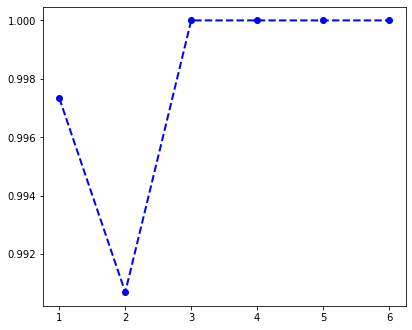

In [17]:
labels = ['20 kHz', '200 kHz', '2 MHz', '20 MHz', '80 MHz', '160 MHz']
legend = ['Autoencoder', 'IF', 'LOF', 'COPOD', 'OC-SVM']
line= ['bo--','rv-.','g*:','yo--','mv-.']


for i in range(2):
    for attack in averages[i].keys():
        fig,ax = plt.subplots()
        fig.set_size_inches(6.5, 5.5, forward=True)
        x = [1, 2, 3, 4, 5, 6]

        for m in range(len(model_names)):
            mod=model_names[m]
            plt.plot(x, averages[i][attack][mod].values(), line[m], linewidth=2)

        plt.title(attack, fontsize = 20)
        plt.xlabel("Bandwidth", fontsize = 15)
        plt.ylabel("TPR (%)", fontsize = 15)

        axes = plt.gca()
        axes.set_ylim([-0.05,1.05])

        plt.legend(legend, fontsize = 13)
        plt.xticks(x, labels)
        plt.rc('xtick', labelsize=15)
        plt.rc('ytick', labelsize=15)

        #plt.margins(0.2)

        # Tweak spacing to prevent clipping of tick-labels
        plt.subplots_adjust(bottom = 0.15)
        plt.savefig(attack+'_family_RPi'+str(3+i)+'_automated.pdf') 
        plt.show()
    
    